In [13]:
path = "COCO" # dataset root dir
train = "train2017.txt" # train images (relative to 'path') 118287 images
val = "val2017.txt" # val images (relative to 'path') 5000 images
test = "test-dev2017.txt" # 20288 of 40670 images, submit to https://competitions.codalab.org/competitions/20794

# Classes
names = {
  0: "person",
  1: "bicycle",
  2: "car",
  3: "motorcycle",
  4: "airplane",
  5: "bus",
  6: "train",
  7: "truck",
  8: "boat",
  9: "traffic light",
  10: "fire hydrant",
  11: "stop sign",
  12: "parking meter",
  13: "bench",
  14: "bird",
  15: "cat",
  16: "dog",
  17: "horse",
  18: "sheep",
  19: "cow",
  20: "elephant",
  21: "bear",
  22: "zebra",
  23: "giraffe",
  24: "backpack",
  25: "umbrella",
  26: "handbag",
  27: "tie",
  28: "suitcase",
  29: "frisbee",
  30: "skis",
  31: "snowboard",
  32: "sports ball",
  33: "kite",
  34: "baseball bat",
  35: "baseball glove",
  36: "skateboard",
  37: "surfboard",
  38: "tennis racket",
  39: "bottle",
  40: "wine glass",
  41: "cup",
  42: "fork",
  43: "knife",
  44: "spoon",
  45: "bowl",
  46: "banana",
  47: "apple",
  48: "sandwich",
  49: "orange",
  50: "broccoli",
  51: "carrot",
  52: "hot dog",
  53: "pizza",
  54: "donut",
  55: "cake",
  56: "chair",
  57: "couch",
  58: "potted plant",
  59: "bed",
  60: "dining table",
  61: "toilet",
  62: "tv",
  63: "laptop",
  64: "mouse",
  65: "remote",
  66: "keyboard",
  67: "cell phone",
  68: "microwave",
  69: "oven",
  70: "toaster",
  71: "sink",
  72: "refrigerator",
  73: "book",
  74: "clock",
  75: "vase",
  76: "scissors",
  77: "teddy bear",
  78: "hair drier",
  79: "toothbrush"}


import sys
sys.path.append('../')
# Download script/URL (optional)
from ultralytics.utils.downloads import download
from pathlib import Path
import os

# Download labels
segments = False  # segment or box labels
dir = Path(path)  # dataset root dir
url = 'https://github.com/ultralytics/yolov5/releases/download/v1.0/'
urls = [url + ('coco2017labels-segments.zip' if segments else 'coco2017labels.zip')]  # labels
# download(urls, dir=dir.parent)
#
# TODO move coco/* TO your path
#
# Download data
urls = ['http://images.cocodataset.org/zips/train2017.zip',  # 19G, 118k images
          'http://images.cocodataset.org/zips/val2017.zip',  # 1G, 5k images
          'http://images.cocodataset.org/zips/test2017.zip']  # 7G, 41k images (optional)
# download(urls, dir=dir / 'images', threads=3)

100%|██████████| 46.4M/46.4M [00:09<00:00, 4.93MB/s]
Unzipping coco2017labels.zip to /home/mdesmarescaux/git/Yolov8_OneShot/data/coco...: 100%|██████████| 122232/122232 [00:12<00:00, 9918.13file/s] 


In [7]:
import os

add_paths = [
         'COCO/support',
        ]

for i in add_paths:
    if not os.path.exists(i):
        os.mkdir(i)

In [12]:
!rm -rf COCO/annotations/
!rm coco2017labels.zip

#and other folder

rm: impossible de supprimer 'coco2017labels.zip': Aucun fichier ou dossier de ce type


# TODO copie coller

<!-- # Ultralytics YOLO 🚀, AGPL-3.0 license
# COCO 2017 dataset https://cocodataset.org by Microsoft
# Documentation: https://docs.ultralytics.com/datasets/detect/coco/
# Example usage: yolo train data=coco.yaml
# parent
# ├── ultralytics
# └── datasets
#     └── coco  ← downloads here (20.1 GB)

# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path: ../datasets/coco # dataset root dir
train: train2017.txt # train images (relative to 'path') 118287 images
val: val2017.txt # val images (relative to 'path') 5000 images
test: test-dev2017.txt # 20288 of 40670 images, submit to https://competitions.codalab.org/competitions/20794

# Classes
names:
  0: person
  1: bicycle
  2: car
  3: motorcycle
  4: airplane
  5: bus
  6: train
  7: truck
  8: boat
  9: traffic light
  10: fire hydrant
  11: stop sign
  12: parking meter
  13: bench
  14: bird
  15: cat
  16: dog
  17: horse
  18: sheep
  19: cow
  20: elephant
  21: bear
  22: zebra
  23: giraffe
  24: backpack
  25: umbrella
  26: handbag
  27: tie
  28: suitcase
  29: frisbee
  30: skis
  31: snowboard
  32: sports ball
  33: kite
  34: baseball bat
  35: baseball glove
  36: skateboard
  37: surfboard
  38: tennis racket
  39: bottle
  40: wine glass
  41: cup
  42: fork
  43: knife
  44: spoon
  45: bowl
  46: banana
  47: apple
  48: sandwich
  49: orange
  50: broccoli
  51: carrot
  52: hot dog
  53: pizza
  54: donut
  55: cake
  56: chair
  57: couch
  58: potted plant
  59: bed
  60: dining table
  61: toilet
  62: tv
  63: laptop
  64: mouse
  65: remote
  66: keyboard
  67: cell phone
  68: microwave
  69: oven
  70: toaster
  71: sink
  72: refrigerator
  73: book
  74: clock
  75: vase
  76: scissors
  77: teddy bear
  78: hair drier
  79: toothbrush

# Download script/URL (optional)
download: |
  from ultralytics.utils.downloads import download
  from pathlib import Path

  # Download labels
  segments = True  # segment or box labels
  dir = Path(yaml['path'])  # dataset root dir
  url = 'https://github.com/ultralytics/yolov5/releases/download/v1.0/'
  urls = [url + ('coco2017labels-segments.zip' if segments else 'coco2017labels.zip')]  # labels
  download(urls, dir=dir.parent)
  # Download data
  urls = ['http://images.cocodataset.org/zips/train2017.zip',  # 19G, 118k images
          'http://images.cocodataset.org/zips/val2017.zip',  # 1G, 5k images
          'http://images.cocodataset.org/zips/test2017.zip']  # 7G, 41k images (optional)
  download(urls, dir=dir / 'images', threads=3) -->

100%|██████████| 4952/4952 [00:00<00:00, 32259.37it/s]


80


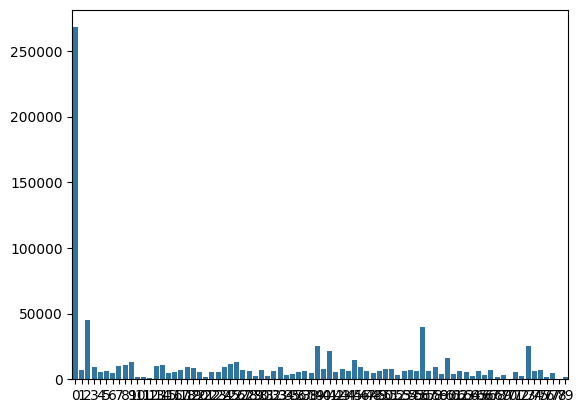

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import glob

a = []

for year, image_set in ('2017', 'train'), ('2017', 'val'):
    lbs_path = dir / 'labels' / f'{image_set}{year}/*'

    for i in tqdm(glob.glob(str(lbs_path))):
        with open(i,'+r') as f:
            info = f.read().strip().split()
            size = len(info)
            for y in range(0,size,5):
                inf = info[y:y+5]
                a.append(inf[0])   

count = {i:a.count(str(i)) for i in range(0,80)}
print(len(count))

plt.figure()
sns.barplot(x=range(0,80),y=count.values())
plt.show()

In [45]:
#label/train2017 -> label/train2017all
os.rename("COCO/labels/train2017", "COCO/labels/train2017all/")

import os

add_paths = [
        'COCO/labels/train1',
        'COCO/labels/train2',
        'COCO/labels/train3',
        'COCO/labels/train4',
        ]

for i in add_paths:
    if not os.path.exists(i):
        os.mkdir(i)

FileNotFoundError: [Errno 2] No such file or directory: 'COCO/labels/train2017' -> 'COCO/labels/train2017all/'

In [47]:
#SPLIT 1

novel1 = [0,4,8,12,16,20,24,28,32,36,40,44,48,52,56,60,64,68,72,76]
novel2 = [1,5,9,13,17,21,25,29,33,37,41,45,49,53,57,61,65,69,73,77]
novel3 = [2,6,10,14,18,22,26,30,34,38,42,46,50,54,58,62,66,70,74,78]
novel4 = [3,7,11,15,19,23,27,31,35,39,43,47,51,55,59,63,67,71,75,79]

for year, image_set in ('2017all', 'train'),:
    lbs_path = dir / 'labels' / f'{image_set}{year}/*'

    for i in tqdm(glob.glob(str(lbs_path))):
        a = []
        b = []
        c = []
        d = []
        with open(i,'+r') as f:
            info = f.read().strip().split()
            size = len(info)
            for y in range(0,size,5):
                inf = info[y:y+5]
                if int(inf[0]) in novel1:
                    a.append([z for z in inf])
                if int(inf[0]) in novel2:
                    b.append([z for z in inf])
                if int(inf[0]) in novel3:
                    c.append([z for z in inf])
                if int(inf[0]) in novel4:
                    d.append([z for z in inf])
        if len(b) != 0 or len(c) != 0 or len(d) != 0:
            with open('COCO/labels/train1/'+i.split('/')[-1],'+w') as f:
                for y in b+c+d:
                    f.write(str(' '.join(y)+'\n'))                
        if len(a) != 0 or len(c) != 0 or len(d) != 0:
            with open('COCO/labels/train2/'+i.split('/')[-1],'+w') as f:
                for y in a+c+d:
                    f.write(str(' '.join(y)+'\n'))      
        if len(a) != 0 or len(b) != 0 or len(d) != 0:
            with open('COCO/labels/train3/'+i.split('/')[-1],'+w') as f:
                for y in a+b+d:
                    f.write(str(' '.join(y)+'\n'))     
        if len(a) != 0 or len(b) != 0 or len(c) != 0:
            with open('COCO/labels/train4/'+i.split('/')[-1],'+w') as f:
                for y in a+b+c:
                    f.write(str(' '.join(y)+'\n'))     

100%|██████████| 117266/117266 [00:38<00:00, 3010.57it/s]


In [50]:
print(len(glob.glob("COCO/labels/train1/*.txt")))
print(len(glob.glob("COCO/labels/train2/*.txt")))
print(len(glob.glob("COCO/labels/train3/*.txt")))
print(len(glob.glob("COCO/labels/train4/*.txt")))
print(len(glob.glob("COCO/labels/train2017all/*.txt")))

106498
111369
108557
110201
117266


# Base on DANA support IMAGE

In [62]:
#!wget -O support.zip "https://drive.google.com/uc?export=download&id=1nl9-DEpBBJ5w6hxVdijY6hFxoQdz8aso&confirm=yes"

!wget -O support.zip 'https://drive.usercontent.google.com/download?id=1nl9-DEpBBJ5w6hxVdijY6hFxoQdz8aso&export=download&authuser=0&confirm=yes'

--2024-04-11 16:41:13--  https://drive.usercontent.google.com/download?id=1nl9-DEpBBJ5w6hxVdijY6hFxoQdz8aso&export=download&authuser=0&confirm=yes
Résolution de drive.usercontent.google.com (drive.usercontent.google.com)… 216.58.213.65
Connexion à drive.usercontent.google.com (drive.usercontent.google.com)|216.58.213.65|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 83542467 (80M) [application/octet-stream]
Enregistre : «support.zip»

support.zip         100%[===================>]  79,67M  1,43MB/s    ds 46s     

2024-04-11 16:42:02 (1,74 MB/s) - «support.zip» enregistré [83542467/83542467]



In [63]:
!unzip support.zip

Archive:  support.zip
   creating: supports/
   creating: supports/all/
   creating: supports/all/airplane/
  inflating: supports/all/airplane/5_115178.jpg  
  inflating: supports/all/airplane/5_119232.jpg  
  inflating: supports/all/airplane/5_162257.jpg  
  inflating: supports/all/airplane/5_208901.jpg  
  inflating: supports/all/airplane/5_229747.jpg  
  inflating: supports/all/airplane/5_255482.jpg  
  inflating: supports/all/airplane/5_266099.jpg  
  inflating: supports/all/airplane/5_277146.jpg  
  inflating: supports/all/airplane/5_295765.jpg  
  inflating: supports/all/airplane/5_298440.jpg  
  inflating: supports/all/airplane/5_311619.jpg  
  inflating: supports/all/airplane/5_349804.jpg  
  inflating: supports/all/airplane/5_408112.jpg  
  inflating: supports/all/airplane/5_445561.jpg  
  inflating: supports/all/airplane/5_464706.jpg  
  inflating: supports/all/airplane/5_513580.jpg  
  inflating: supports/all/airplane/5_514321.jpg  
  inflating: supports/all/airplane/5_52485

In [69]:
from PIL import Image, ImageOps

def resize_with_padding(img, expected_size):
    width, height = img.size
    ratio = width / height
    if width < height:
        img = img.resize((int(ratio*expected_size[0]),int(expected_size[0])))
    else:
        img = img.resize((int(expected_size[1]),int((1/ratio)*expected_size[1])))
        
    img.thumbnail((expected_size[0], expected_size[1]))
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)

for i,j in names.items():
    liste = glob.glob('supports/all/'+j+'/*')
    f = liste[2]
    image = Image.open(f)
    image = resize_with_padding(image, (640,640))
    image.save("COCO/support/"+str(i)+'.png')


In [70]:
!rm -rf support.zip

In [71]:
!rm -rf supports